In [1]:
#CS 4342 - Utku Mert Yakar - Final Project

6.1. Reading the Dataset [10 points]
- Load the dataset using PyTorch.
- Perform necessary preprocessing, such as resizing images to 32 × 32, normalizing pixel
values, and converting them into tensors. 
- Apply data augmentation methods such as
random flips, rotations, etc., as needed.
- Split the dataset into training and test sets. You can use an 80/20 ratio for training
and testing

In [2]:
import torch
print(torch.cuda.is_available()) 
print(torch.version.cuda)

True
11.8


In [3]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

#Use a gpu if possible, otherwise the training will take so long
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

#Defining the transforms here
train_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

#Loading the full dataset - training images
data_dir = './Data' 
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transforms)

#Splitting the dataset into training and test datasets - w/ 80-20 split
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

test_dataset.dataset.transform = test_transforms

#Dataloaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

print("Number of training samples:", len(train_dataset))
print("Number of testing samples:", len(test_dataset))


Using device: cuda
Number of training samples: 41505
Number of testing samples: 10377


6.2 Visualizing the Data
- Here, we visualize one example from the training set.
- We apply the inverse of normalization for visualization.
- Ensure the class-to-index mapping is available if you want to print the label name.

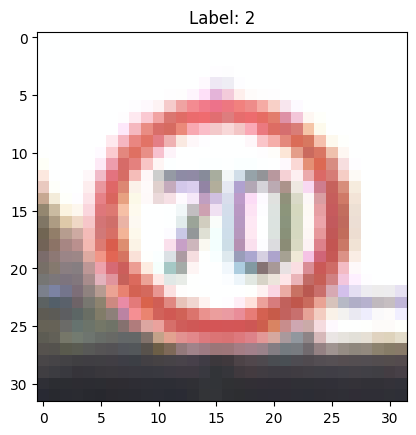

In [28]:
import matplotlib.pyplot as plt
import numpy as np

#One batch from the training loader
images, labels = next(iter(train_loader))

#Inv normalization for displaying images
inv_mean = np.array([0.485, 0.456, 0.406])
inv_std = np.array([0.229, 0.224, 0.225])
def unnormalize(img_tensor):
    img = img_tensor.cpu().numpy().transpose((1,2,0))
    img = img * inv_std + inv_mean
    img = np.clip(img, 0, 1)
    return img

#Visualize an example
img = unnormalize(images[0])
label = labels[0].item()

plt.imshow(img)
plt.title(f"Label: {label}") 
plt.show()


6.3 Implementing and Training the Custom CNN Model
- Implementing the custom CNN as described:
    - Conv1 → BN → ReLU → Pool
    - Conv2 → BN → ReLU → Pool
    - Flatten → FC1 → ReLU → Dropout → FC2
- Train the model using the GTSRB dataset, track training progress, and evaluate on the test set.

Epoch 1/10: 100%|██████████| 649/649 [00:09<00:00, 66.34it/s] 


Epoch: 1, Train Loss: 0.5963, Train Acc: 0.7467, Test Acc: 0.7562


Epoch 2/10: 100%|██████████| 649/649 [00:09<00:00, 68.63it/s] 


Epoch: 2, Train Loss: 0.5517, Train Acc: 0.7566, Test Acc: 0.7565


Epoch 3/10: 100%|██████████| 649/649 [00:09<00:00, 68.68it/s] 


Epoch: 3, Train Loss: 0.5368, Train Acc: 0.7589, Test Acc: 0.7656


Epoch 4/10: 100%|██████████| 649/649 [00:09<00:00, 69.14it/s] 


Epoch: 4, Train Loss: 0.5089, Train Acc: 0.7703, Test Acc: 0.7751


Epoch 5/10: 100%|██████████| 649/649 [00:09<00:00, 69.14it/s] 


Epoch: 5, Train Loss: 0.4755, Train Acc: 0.7841, Test Acc: 0.7929


Epoch 6/10: 100%|██████████| 649/649 [00:09<00:00, 69.88it/s] 


Epoch: 6, Train Loss: 0.4303, Train Acc: 0.8059, Test Acc: 0.8271


Epoch 7/10: 100%|██████████| 649/649 [00:09<00:00, 69.47it/s] 


Epoch: 7, Train Loss: 0.3832, Train Acc: 0.8263, Test Acc: 0.8425


Epoch 8/10: 100%|██████████| 649/649 [00:09<00:00, 69.89it/s] 


Epoch: 8, Train Loss: 0.3382, Train Acc: 0.8497, Test Acc: 0.8621


Epoch 9/10: 100%|██████████| 649/649 [00:09<00:00, 69.46it/s] 


Epoch: 9, Train Loss: 0.3005, Train Acc: 0.8663, Test Acc: 0.8849


Epoch 10/10: 100%|██████████| 649/649 [00:09<00:00, 69.31it/s] 


Epoch: 10, Train Loss: 0.2607, Train Acc: 0.8860, Test Acc: 0.8903


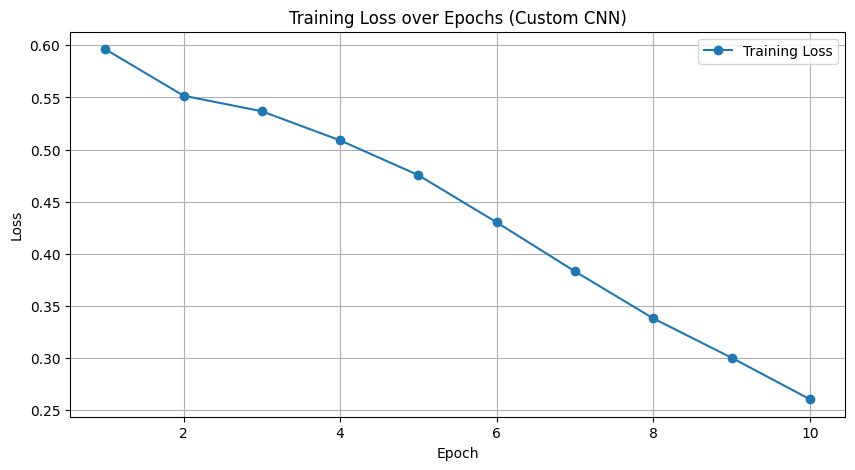

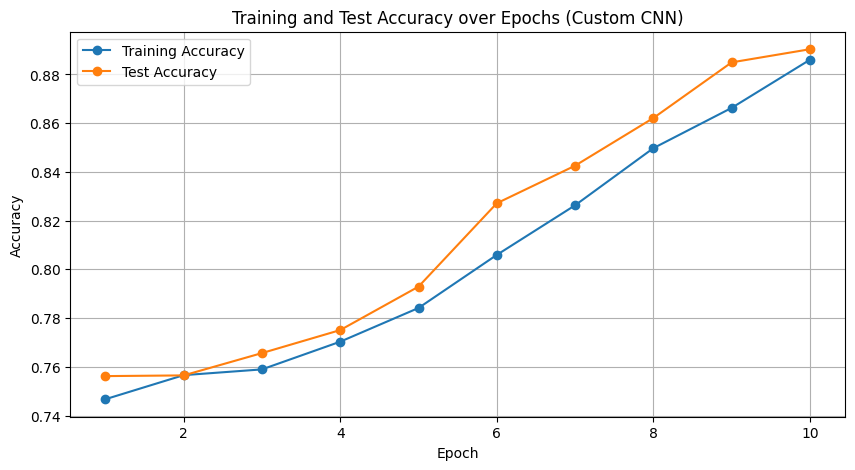

Final Test Accuracy (Custom CNN): 0.8903343933699528


In [13]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

#Defining the custom cnn architecture
class CustomCNN(nn.Module):
    def __init__(self, num_classes=43):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        #After pooling twice
        # Inp: 32x32 -> Pool -> 16x16 -> Pool -> 8x8
        # Flattened: 64 * 8 * 8 = 4096
        self.fc1 = nn.Linear(64*8*8, 512)
        self.dropout = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

#Init model, loss func and optimizer
model_custom = CustomCNN(num_classes=43).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_custom.parameters(), lr=0.001)

#Lists for storing the metrics per epoch
train_losses = []
train_accuracies = []
test_accuracies = []

epochs = 10
for epoch in range(epochs):
    model_custom.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_custom(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    #Test set evalatuation
    model_custom.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_custom(images)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    test_acc = correct_test / total_test

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

#Plot the training loss
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_losses, marker='o', label='Training Loss')
plt.title("Training Loss over Epochs (Custom CNN)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

#Plot the training and test acc
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, epochs+1), test_accuracies, marker='o', label='Test Accuracy')
plt.title("Training and Test Accuracy over Epochs (Custom CNN)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

#Final test acc
print("Final Test Accuracy (Custom CNN):", test_accuracies[-1])


6.4. Fine-Tuning Pre-trained Models [15 points]
- Load Pretrained ResNet50 and VGG16 using Pytorch.
- Fine-tune the ResNet50 and VGG16 on the GTSRB dataset using transfer learning in
PyTorch.
- Replace the final layers of the pre-trained models to match the number of classes in
the GTSRB dataset.

ResNet50

ResNet50 Epoch 1/10: 100%|██████████| 649/649 [00:17<00:00, 37.85it/s]


ResNet50 Epoch: 1, Train Loss: 0.5451, Train Acc: 0.7816, Test Acc: 0.8617


ResNet50 Epoch 2/10: 100%|██████████| 649/649 [00:22<00:00, 29.38it/s]


ResNet50 Epoch: 2, Train Loss: 0.2536, Train Acc: 0.8955, Test Acc: 0.9192


ResNet50 Epoch 3/10: 100%|██████████| 649/649 [00:21<00:00, 29.69it/s]


ResNet50 Epoch: 3, Train Loss: 0.1500, Train Acc: 0.9398, Test Acc: 0.9382


ResNet50 Epoch 4/10: 100%|██████████| 649/649 [00:21<00:00, 30.05it/s]


ResNet50 Epoch: 4, Train Loss: 0.1085, Train Acc: 0.9595, Test Acc: 0.9534


ResNet50 Epoch 5/10: 100%|██████████| 649/649 [00:17<00:00, 36.34it/s]


ResNet50 Epoch: 5, Train Loss: 0.0791, Train Acc: 0.9710, Test Acc: 0.9610


ResNet50 Epoch 6/10: 100%|██████████| 649/649 [00:12<00:00, 52.62it/s]


ResNet50 Epoch: 6, Train Loss: 0.0691, Train Acc: 0.9747, Test Acc: 0.9640


ResNet50 Epoch 7/10: 100%|██████████| 649/649 [00:12<00:00, 53.34it/s]


ResNet50 Epoch: 7, Train Loss: 0.0560, Train Acc: 0.9805, Test Acc: 0.9689


ResNet50 Epoch 8/10: 100%|██████████| 649/649 [00:12<00:00, 51.13it/s]


ResNet50 Epoch: 8, Train Loss: 0.0525, Train Acc: 0.9821, Test Acc: 0.9635


ResNet50 Epoch 9/10: 100%|██████████| 649/649 [00:22<00:00, 28.74it/s]


ResNet50 Epoch: 9, Train Loss: 0.0439, Train Acc: 0.9849, Test Acc: 0.9749


ResNet50 Epoch 10/10: 100%|██████████| 649/649 [00:22<00:00, 28.49it/s]


ResNet50 Epoch: 10, Train Loss: 0.0384, Train Acc: 0.9867, Test Acc: 0.9756


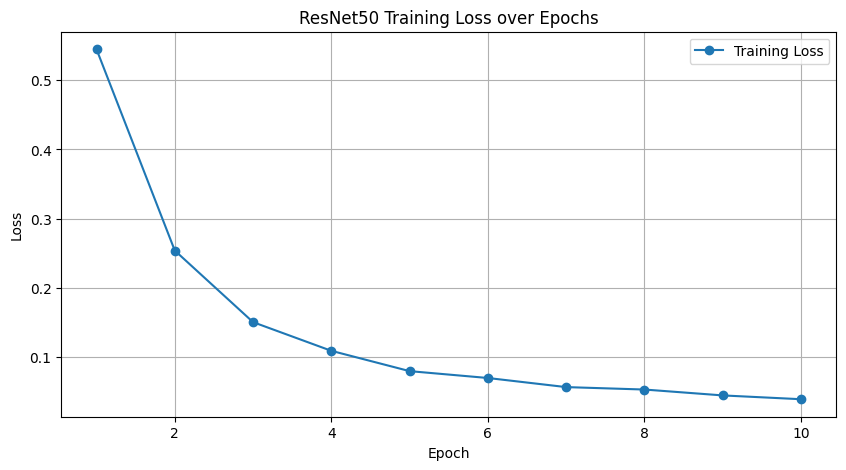

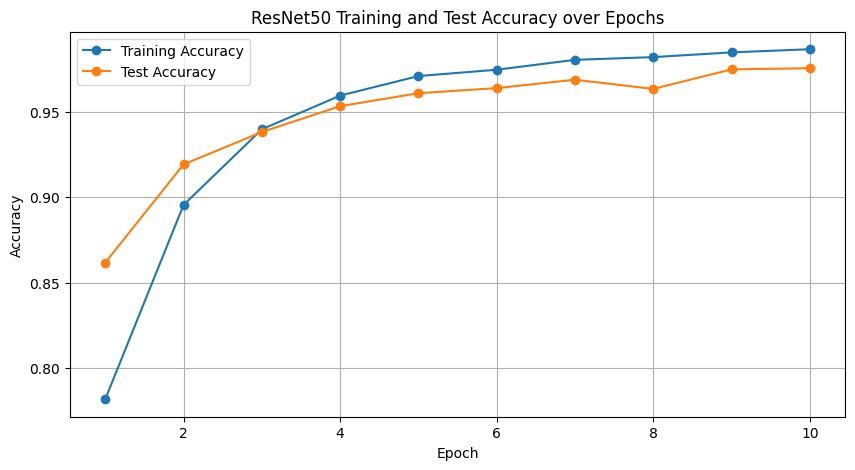

Final Test Accuracy (ResNet50): 0.9756191577527223


In [20]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

#Loading a pretrained ResNet50 model
model_resnet = models.resnet50(pretrained=True)

#Replacing the last fully connected layer for 43 classes - #of classes in the dataset
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 43)
model_resnet = model_resnet.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.parameters(), lr=0.0001)

#Storing metrics
resnet_train_losses = []
resnet_train_accuracies = []
resnet_test_accuracies = []

epochs = 10
for epoch in range(epochs):
    model_resnet.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"ResNet50 Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_resnet(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    #Evaluate
    model_resnet.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_resnet(images)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    test_acc = correct_test / total_test

    resnet_train_losses.append(train_loss)
    resnet_train_accuracies.append(train_acc)
    resnet_test_accuracies.append(test_acc)

    print(f"ResNet50 Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

#Plot results
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), resnet_train_losses, marker='o', label='Training Loss')
plt.title("ResNet50 Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), resnet_train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, epochs+1), resnet_test_accuracies, marker='o', label='Test Accuracy')
plt.title("ResNet50 Training and Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

print("Final Test Accuracy (ResNet50):", resnet_test_accuracies[-1])


VGG16

VGG16 Epoch 1/10: 100%|██████████| 649/649 [00:17<00:00, 36.85it/s]


VGG16 Epoch: 1, Train Loss: 0.5644, Train Acc: 0.7566, Test Acc: 0.7954


VGG16 Epoch 2/10: 100%|██████████| 649/649 [00:16<00:00, 39.38it/s]


VGG16 Epoch: 2, Train Loss: 0.3446, Train Acc: 0.8502, Test Acc: 0.8882


VGG16 Epoch 3/10: 100%|██████████| 649/649 [00:17<00:00, 37.38it/s]


VGG16 Epoch: 3, Train Loss: 0.1786, Train Acc: 0.9259, Test Acc: 0.9377


VGG16 Epoch 4/10: 100%|██████████| 649/649 [00:17<00:00, 37.30it/s]


VGG16 Epoch: 4, Train Loss: 0.1009, Train Acc: 0.9608, Test Acc: 0.9376


VGG16 Epoch 5/10: 100%|██████████| 649/649 [00:17<00:00, 37.79it/s]


VGG16 Epoch: 5, Train Loss: 0.0631, Train Acc: 0.9759, Test Acc: 0.9509


VGG16 Epoch 6/10: 100%|██████████| 649/649 [00:17<00:00, 38.04it/s]


VGG16 Epoch: 6, Train Loss: 0.0550, Train Acc: 0.9799, Test Acc: 0.9624


VGG16 Epoch 7/10: 100%|██████████| 649/649 [00:17<00:00, 37.22it/s]


VGG16 Epoch: 7, Train Loss: 0.0373, Train Acc: 0.9870, Test Acc: 0.9672


VGG16 Epoch 8/10: 100%|██████████| 649/649 [00:16<00:00, 39.05it/s]


VGG16 Epoch: 8, Train Loss: 0.0339, Train Acc: 0.9884, Test Acc: 0.9688


VGG16 Epoch 9/10: 100%|██████████| 649/649 [00:17<00:00, 38.17it/s]


VGG16 Epoch: 9, Train Loss: 0.0257, Train Acc: 0.9910, Test Acc: 0.9695


VGG16 Epoch 10/10: 100%|██████████| 649/649 [00:16<00:00, 38.36it/s]


VGG16 Epoch: 10, Train Loss: 0.0273, Train Acc: 0.9910, Test Acc: 0.9642


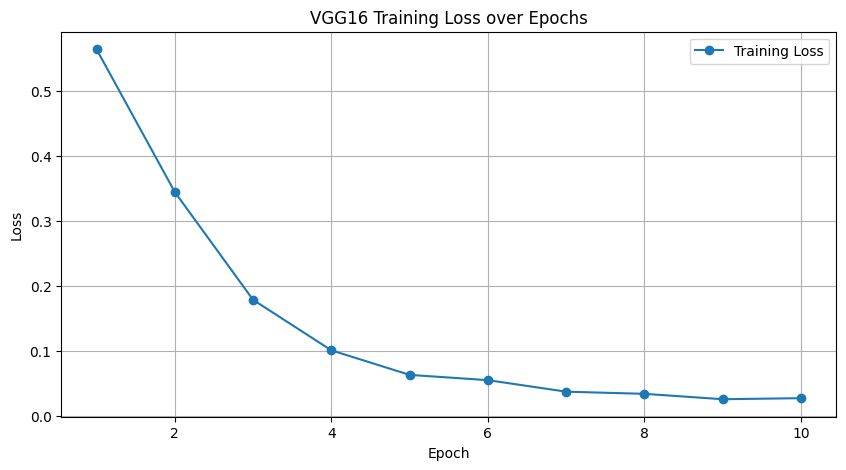

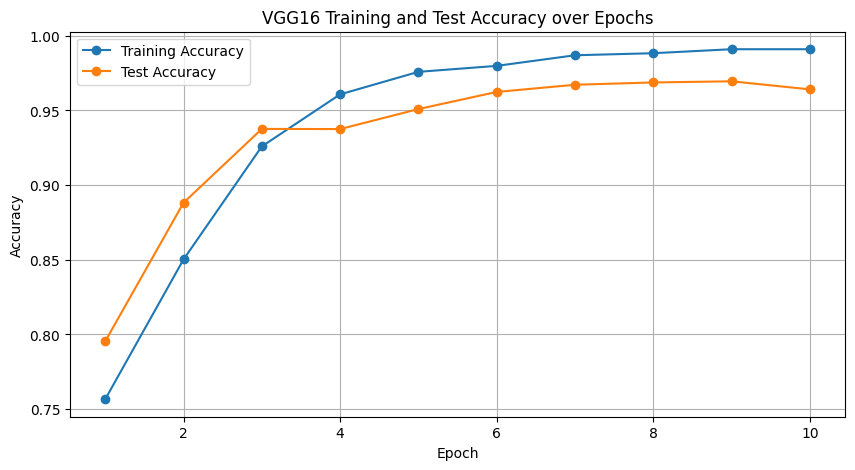

Final Test Accuracy (VGG16): 0.9641514888696155


In [24]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

#Loading the pretrained VGG16 model
model_vgg = models.vgg16(pretrained=True)

#Replacing the last classification layer to output 43 classes -same reason
num_ftrs = model_vgg.classifier[6].in_features
model_vgg.classifier[6] = nn.Linear(num_ftrs, 43)

model_vgg = model_vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg.parameters(), lr=0.0001)

#Storing metrics again
vgg_train_losses = []
vgg_train_accuracies = []
vgg_test_accuracies = []

epochs = 10
for epoch in range(epochs):
    model_vgg.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader, desc=f"VGG16 Epoch {epoch+1}/{epochs}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_vgg(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader.dataset)
    train_acc = correct / total

    #Evaluate on test set
    model_vgg.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model_vgg(images)
            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)
    test_acc = correct_test / total_test

    vgg_train_losses.append(train_loss)
    vgg_train_accuracies.append(train_acc)
    vgg_test_accuracies.append(test_acc)

    print(f"VGG16 Epoch: {epoch+1}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}")

#Plot the results
plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), vgg_train_losses, marker='o', label='Training Loss')
plt.title("VGG16 Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(range(1, epochs+1), vgg_train_accuracies, marker='o', label='Training Accuracy')
plt.plot(range(1, epochs+1), vgg_test_accuracies, marker='o', label='Test Accuracy')
plt.title("VGG16 Training and Test Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

print("Final Test Accuracy (VGG16):", vgg_test_accuracies[-1])
